In [3]:
from IPython.display import Image

In [4]:
#Please change the filepath accordingly
fp='/Users/mariusunger/Downloads/komprimiert/'

# Predicting Bitcoin price with Twitter sentiment analysis

by Jan Patzke (549261) and Marius Unger (546926)

# 1 Introduction

This notebook follows the purpose of predicting Bitcoin time series data based on Twitter sentiment analysis. The main focus throughout this notebook lies on the prediction. The sentimental analysis is performed by the TextBlob [1] module. The prediction will be perforemd by a Long-Short-Term-Memory (LSTM) model, which is part of the Keras layers module [2]. We therefore considered hourly Bitcoin and Twitter data provided by the twitterscraper API [3] and an open source API for scraping Bitcoin prices [4]. 

# 2 The LSTM model

# 2.1 Artificial Neural Networks

The most basic ANN architectures are Perceptrons. Each neuron receeives a weighted sum $z={w}_{1}{x}_{1}+{w}_{2}{x}_{2}+...+{w}_{n}{x}_{n}$ as an input. This input is then transformed by a so called activation function ${h}_{w}(x)=f(z)$. This corresponds to the following figure. 

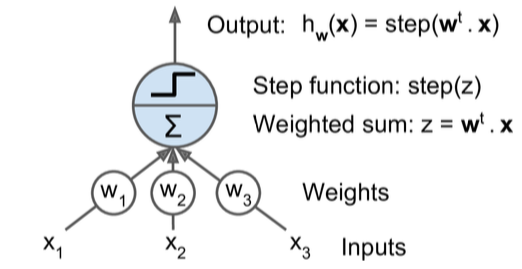

In [73]:
#This image is taken from [5] p. 257
Image(fp+'ANN.png')

This weigths are successively being updated by the so called Hebb's rule. This basically says that a Perceptron is being fed by one training instance at a time and for each instance it makes predictions. For each wrong output, it reinforces the weights, that contributed to the wrong output. 

The next architectural evolution are so called Multi-Layer Perceptrons (MLPs). It is composed of one input Layer and one or more hidden layers. The final layer is then called output layer. An ANN with two or more hidden layers is called deep neural network. 
The weights of an MLP are trained by means of the so called backpropagation algorithm. This algorithm measures the newtorks output error and tracks how much each neuron in the previous layer contributed to that error until the algorithm reaches the input layer. By minimizing the error, the connection weights are updated and tweaked (Gradient Descent algorithm). In order to minimize the error, a differentiable activation function is needed. A widely used option is the so called logistic function $f(x)=L/(1+exp(-k(x-x_0))$ [5]. 

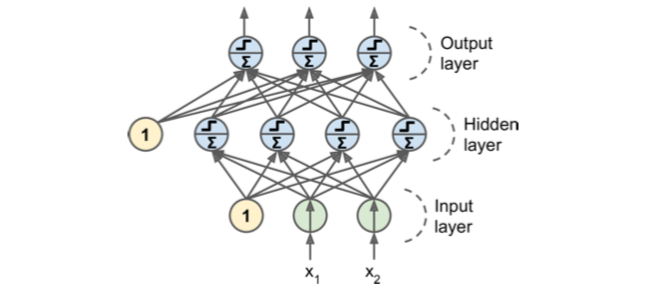

In [74]:
#This image is taken from [5] p. 258
Image(fp+'MLP.png')

Other Activation Functions would be Sigmoid Function $f(x)=1/(1+exp(-x))$ which is a special case of the logistic function with L=1, k=1, x_0=0 . The range of values of the sigmoid function lies between [0,1]. This makes it usable to get an output similar to probabilities.

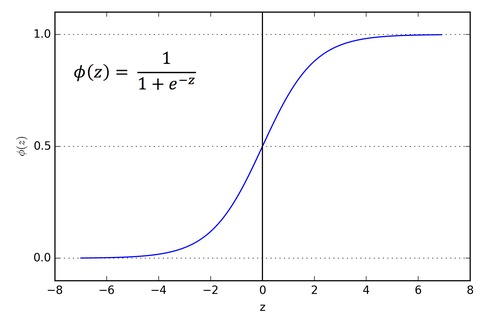

In [5]:
#*https://www.ai-united.de/aktivierungsfunktionen-neuronale-netze/
Image(fp+'sigmoidfunc.png') 

Next would be the tanh. It takes vales between -1 and 1 which makes it better in some cases than the sigmoid function.

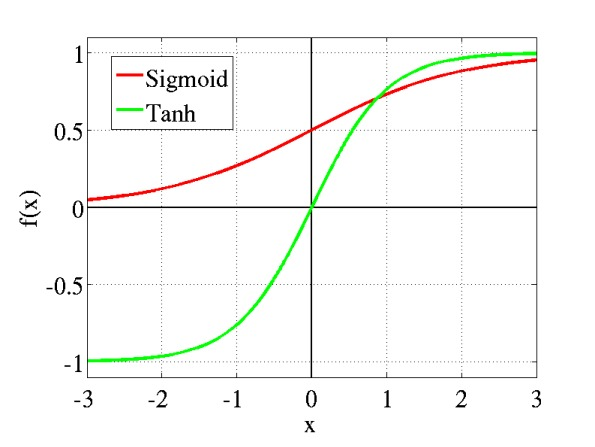

In [7]:
Image(fp+'tanhfunc.png')

Another one would be the Relu Function (rectified linear unit) which is defined as $f(x)=max(0,x)$.
It transforms all values which are negative to zero. This speeds up the learning process, but at the same time in certain situations you want some negative values.  

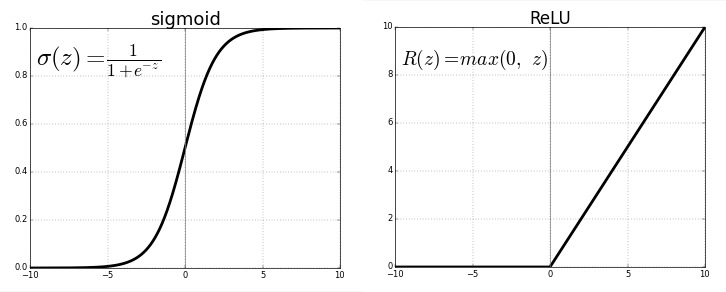

In [8]:
Image(fp+'relunc.png')

The main reason why Neural Networks are getting more and more important is, that the performance of the prediction of a Neural Network does not stagnate as fast as tradiotional statistics based on the amount of data.

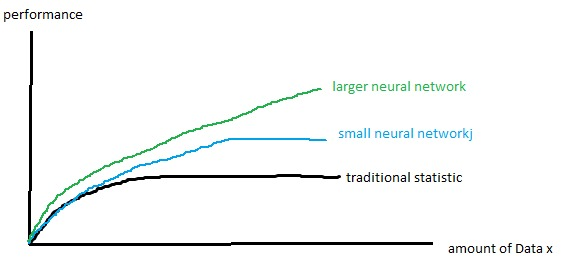

In [9]:
Image(fp+'performance.png')

Another topic would be the type of data which is used. We differenciate between unstructered (images) and structured (stock prices) data.
In the next chapter we explain how to learn on time-series data.

# 2.2 Recurrent Neural Networks

Recurrent Neural Networks (RNNs) are used to predict the future based on sequenced data, as for example time series or the ending of a sentence. 
The main difference to the MLPs is that edges from a neuron can be pointing backwards, meaning that the graph of the network is allowed to contain circles. At each point in time $t$ a neuron receives the input ${x}_{t}$ as well as the ouput of the previous time step ${y}_{t-1}$. This concept is illustrated in the following figure [5].

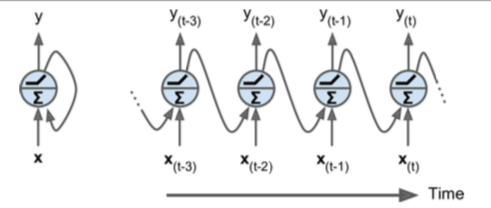

In [75]:
#This image is taken from [5] p. 380
Image(fp+'RNN.png')

The ouput of each recurrent neuron follows the following equation, where $f(\cdot)$ is the activation function and $b$ is the bias term:
${y}_{t}=f({x}_{t}^{T}\cdot{w}_{x}+{y}_{t-1}^{T}\cdot{w}_{y}+b)$.


Long Short-Term Memory (LSMT) models are a subclass of RNNs. The basic architecture is illustrated in the following figure:

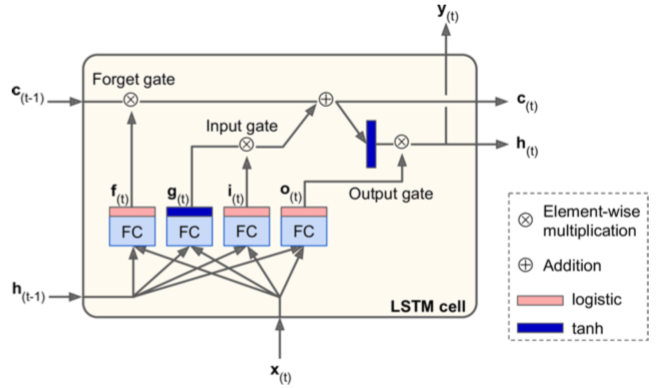

In [76]:
#This image is taken from [5] p. 401
Image(fp+'LSTM.png')

As you can see there are two main states: ${h}_{t}$, the short-term state and ${c}_{t}$, the long-term state.
The main idea is that the LSTM-cell is able to recognize important input and store it in the long-term state, but also being able to forget the information if no longer needed. 

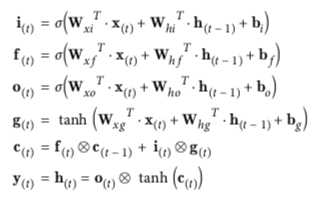

In [10]:
#This image is taken from [5] p. 403
Image(fp+'LSTM_gate_calculation.png')

For further and more detailed information, please refer to [5].

# 3 Applying the model 

# 3.1 Data preprocessing and sample aggregation

In [1]:
"""
Created on Sat Nov 23 15:52:46 2019

@author: jan & marius

coding: utf-8
"""

from twitterscraper import query_tweets
import pandas as pd
from matplotlib import pyplot
import seaborn as sns
import numpy as np
import datetime as dt
from datetime import timedelta
from textblob import TextBlob
import glob
from math import sqrt
from numpy import concatenate
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from numpy.random import seed
import matplotlib.pyplot as plt

INFO: {'User-Agent': 'Mozilla/5.0 (Windows NT 5.2; RW; rv:7.0a1) Gecko/20091211 SeaMonkey/9.23a1pre'}
Using TensorFlow backend.


In [2]:
#Load data from local drive and concatenate to one dataframe
path = '/Users/mariusunger/Downloads/komprimiert/datenssatz tweets' # use your path
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

frame = pd.concat(li, axis=0, ignore_index=True)
df_reduced = frame

In [3]:
df_reduced.head()

,Unnamed: 0,text,timestamp,timestamp_epochs,polarity,subjectivity
0,0,"Hi, Join Airdrop Bitnomo and get a free NOMO #...",2019-11-22 13:44:18,1574430258,0.400000,0.800000
1,3,Maybe its just Bitcoin a black Friday sale,2019-11-22 13:44:26,1574430266,-0.166667,0.433333
2,10,"BitMEX $BTC Whale:\n$5,000,000 worth of #Bitco...",2019-11-22 13:44:48,1574430288,0.300000,0.100000
3,11,"Bitcoin moving closer to the $7,000 level\n\nA...",2019-11-22 13:44:48,1574430288,0.200000,1.000000
4,13,doomer sure talks about #bitcoin a lot https:/...,2019-11-22 13:44:50,1574430290,0.500000,0.888889


Get tweets with the twitterscraper API, containing "Bitcoin" from 2019-11-22 until 2019-12-30. We use this while-loop to get a higher efficiency meaning more tweets per day, since the API has some inconstistencies.
Furthermore we apply the senitment analysis of the TextBlob API, which returns polarity and subjectivity for every tweet. For further information please refer to [1]. Moreover, we exlude tweets, where the polarity is equal to zero, since we assume that this doesnt have any separation power regarding the Bitcoin prices.  

In [4]:
#
begin_date = dt.date(2019,11,22)
end_date = dt.date(2019,12,30)
time_del=(end_date-begin_date).days
# from datetime import timedelta
# import time
# def get_daily_tweets(begin_date, end_date,time_delay, limit=10, lang = 'english'):
#     while begin_date < end_date:
#         d = timedelta(days=1)
#         #limit = 160000
#         #lang = 'english'
#         tweets = query_tweets("Bitcoin",limit=limit,begindate=begin_date,enddate=begin_date+d,poolsize=time_del-1)
#         df = pd.DataFrame(t.__dict__ for t in tweets)
#         df.sort_values('timestamp_epochs',inplace=True)
#         df = df.reset_index(drop=True)
#         polarity = df.text.apply(lambda s: TextBlob(s).sentiment[0])
#         subjectivity = df.text.apply(lambda s: TextBlob(s).sentiment[1])
#         df_reduced = df[['text', 'timestamp', 'timestamp_epochs']]
#         df_reduced['polarity']=polarity
#         df_reduced['subjectivity']=subjectivity
#         df = df_reduced[df_reduced.polarity != 0]
#         filepath="/Users/jan/Desktop/python scripts/datenssatz tweets/tweets_{}.csv".format(begin_date)
#         df.to_csv(filepath)
#         print(filepath)
#         begin_date=begin_date+d
#         time.sleep(time_delay)

# get_daily_tweets(begin_date,end_date,limit=56000,lang = 'english', time_delay=1900)

In the next step, we load the Bitcoin price data from the API [4], aggregate hourly data and join Bitcoin data with the Twitter sentiment to one dataframe.

In [5]:
timehours = pd.DatetimeIndex(df_reduced['timestamp'])
#round for hours
timehours = timehours.round('H').tz_localize(None) 
df_reduced = df_reduced.drop(['timestamp'],axis=1)
df_reduced['timestamp']=timehours
#Load hourly Bitcoin prices from the API described in [4] based on the command:
#python downloader_crypto.py bitmex BTC/USD 2019-11-10T00:00:00Z 1h btcusd_final.csv
fp="/Users/mariusunger/Downloads/komprimiert/bitcoin data/btcusd_final.csv"
bitcoindata = pd.read_csv(fp)  #http://data.bitcoinity.org/markets/volume/6m?c=e&r=day&t=b
timehours = pd.DatetimeIndex(bitcoindata['Date'])
timehours = timehours.round('H').tz_localize(None)
#Final aggregation by hour
bitcoindata['time_string']=bitcoindata.Date.apply(lambda s: s[0:20])
df_reduced['time_string']=df_reduced.timestamp.astype(str)
df_reduced=df_reduced.merge(bitcoindata[['time_string', 'Open']], on='time_string', how='inner')
df_reduced=df_reduced[['time_string','polarity','subjectivity','Open']]
df_final = df_reduced.groupby('time_string').agg(lambda x: x.mean())
df_final = df_final.rename(columns={'Open':'Price'})

In [6]:
df_final.head()

,polarity,subjectivity,Price
time_string,,,
2019-11-22 14:00:00,0.148003,0.522351,7037.5
2019-11-22 15:00:00,0.162133,0.514581,7033.5
2019-11-22 16:00:00,0.161115,0.513769,7115.5
2019-11-22 17:00:00,0.174549,0.528145,7122.0
2019-11-22 18:00:00,0.165234,0.509216,7145.0


# 3.2 Applying the LSTM model

In this section we apply the LSTM model to the aggregated data. 

In [7]:
seed(1)
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [41]:
#Illustration of the function above. It creates a lookback of each variable based on the number of lags that
#that are given to the function as parameter. This is the input format for the LSTM model.
series_to_supervised(df_final, 2).head()

,var1(t-2),var2(t-2),var1(t-1),var2(t-1),var1(t),var2(t)
time_string,,,,,,
2019-11-22 16:00:00,7037.5,0.148003,7033.5,0.162133,7115.5,0.161115
2019-11-22 17:00:00,7033.5,0.162133,7115.5,0.161115,7122.0,0.174549
2019-11-22 18:00:00,7115.5,0.161115,7122.0,0.174549,7145.0,0.165234
2019-11-22 19:00:00,7122.0,0.174549,7145.0,0.165234,7220.0,0.123943
2019-11-22 20:00:00,7145.0,0.165234,7220.0,0.123943,7298.0,0.134709


In [8]:
#We excluded subjectivity, since it had no impact on the model of earlier iterations
df_final=df_final[['Price','polarity']]

In [21]:
def get_train_test_sample(data, split_ratio, n_hours):
    #normalizes the values to a range between 0 and 1
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(data.values)
    n_features = data.shape[1] 
    n_obs = n_hours*n_features
    #Apply lookback aggregation
    reframed=series_to_supervised(scaled,n_hours)
    values = reframed.values
    #Train-test-split
    n_train_hours = int(len(data)*split_ratio)
    train = values[:n_train_hours, :]
    test = values[n_train_hours:, :]
    # split into input and outputs80
    train_X, train_y = train[:, :n_obs], train[:, -n_features]
    test_X, test_y = test[:, :n_obs], test[:, -n_features]
    # reshape input to be 3D [samples, timesteps, features]
    train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
    test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
    return train_X, test_X, train_y, test_y, scaler

In [22]:
#Define funtion for the LSTM model and give as parameters the data, units (number of hidden layers), the loss-function
#and the numerical optimizier
def LSTM_model(data, units, loss_='mae', optimizer_='adam',activation ='tanh'):
    model = Sequential()
    model.add(LSTM(units, input_shape=(data.shape[1], data.shape[2]),activation))
    model.add(Dense(1))
    model.compile(loss=loss_, optimizer=optimizer_)
    return model

In [53]:
#Define function, that bodies the functions above and executes the prediction itsself.
#Its scales the normalized values back to its original scale and also calculates the MSE and RMSE.

def LSTM_prediction(data, split_ratio, n_hours, units, loss_='mae', optimizer_='adam',activation ='tanh'):
    train_X, test_X, train_y, test_y, scaler=get_train_test_sample(df_final, split_ratio, n_hours)
    model=LSTM_model(train_X, units)
    #fit network
    history = model.fit(train_X, train_y, batch_size=6, validation_data=(test_X, test_y), verbose=2, shuffle=False,validation_split=0.2)  
    yhat = model.predict(test_X)
    test_X=test_X.reshape((test_X.shape[0], n_hours* data.shape[1],))
    inv_yhat = concatenate((yhat, test_X[:, -(data.shape[1]-1):]), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,0]
    test_y = test_y.reshape((len(test_y), 1))
    inv_y = concatenate((test_y, test_X[:, -(data.shape[1]-1):]), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,0]
    # calculate RMSE and MSE
    mse = (mean_squared_error(inv_y, inv_yhat))
    #print('Test MSE: %.3f' % mse)
    rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
    #print('Test RMSE: %.3f' % rmse)
    return inv_y, inv_yhat, mse, rmse

#inv_y is the real Bitcoin price and inv_yhat is the prediction of the model.

In [54]:
#Illustrate functionality
inv_y, inv_yhat, mse, rmse=LSTM_prediction(df_final, 0.8, 2,3)

Train on 601 samples, validate on 149 samples
Epoch 1/1
 - 1s - loss: 0.2746 - val_loss: 0.0528


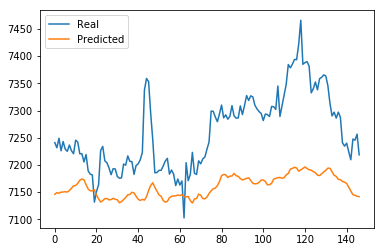

In [65]:
#plot prediction
plt.plot(inv_y, label='Real')
plt.plot(inv_yhat, label="Predicted")  
plt.legend()

In [56]:
#In order to find the best model for our data, we performed some hyperparameter-optimization. 
#We therefore looped over the model parameters "units" and "n_hours" and allways considered the model with the lowest 
#RMSE (Rooted mean square error). The other parameters, like the train-test-split-ratio are considered constant. 
unitslimit=10
unitsstep=1
n_hourslimit=5
bestrmse = 99999999
inv_hatvector= []
rmsevector= []
unitvector= []
n_hourvector= []

In [57]:
for units in range(2,unitslimit,unitsstep):
    for n_hours in range(1,n_hourslimit,1):
        inv_y, inv_yhat, mse, rmse=LSTM_prediction(df_final, 0.8, n_hours, units,activation='relu')
        if rmse < bestrmse:
            bestrmse = rmse
            modelparameter=[units,n_hours]
            inv_yhatbest = inv_yhat
        inv_hatvector.append(inv_yhat)
        rmsevector.append(rmse)
        unitvector.append(units)
        n_hourvector.append(n_hours)

Train on 601 samples, validate on 150 samples
Epoch 1/1
 - 1s - loss: 0.2622 - val_loss: 0.1115
Train on 601 samples, validate on 149 samples
Epoch 1/1
 - 1s - loss: 0.3466 - val_loss: 0.2013
Train on 601 samples, validate on 148 samples
Epoch 1/1
 - 1s - loss: 0.1896 - val_loss: 0.0836
Train on 601 samples, validate on 147 samples
Epoch 1/1
 - 1s - loss: 0.5775 - val_loss: 0.4340
Train on 601 samples, validate on 150 samples
Epoch 1/1
 - 2s - loss: 0.3681 - val_loss: 0.2490
Train on 601 samples, validate on 149 samples
Epoch 1/1
 - 1s - loss: 0.4766 - val_loss: 0.2865
Train on 601 samples, validate on 148 samples
Epoch 1/1
 - 1s - loss: 0.2160 - val_loss: 0.0378
Train on 601 samples, validate on 147 samples
Epoch 1/1
 - 1s - loss: 0.4469 - val_loss: 0.1660
Train on 601 samples, validate on 150 samples
Epoch 1/1
 - 1s - loss: 0.4516 - val_loss: 0.2814
Train on 601 samples, validate on 149 samples
Epoch 1/1
 - 1s - loss: 0.2174 - val_loss: 0.0584
Train on 601 samples, validate on 148 sa

In [58]:
print('bestrmse=',bestrmse)  
print('units=',modelparameter[0])
print('n_hours=',modelparameter[1]) 

bestrmse= 36.72964874916735
units= 9
n_hours= 2


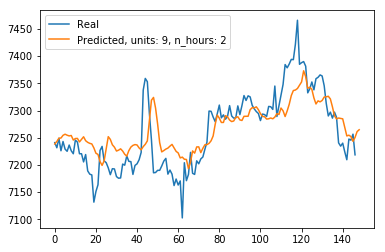

In [66]:
#plot prediction with best rmse 
plt.plot(inv_y, label='Real')
plt.plot(inv_yhatbest, label="Predicted, units: {}, n_hours: {}".format(modelparameter[0], modelparameter[1]))  
plt.legend()

In [60]:
parametermatrix = pd.DataFrame()
parametermatrix['rmse'] = rmsevector
parametermatrix['units']= unitvector
parametermatrix['n_hours']=n_hourvector

In [61]:
parametermatrix.sort_values(by='rmse', ascending=True).head(10)

,rmse,units,n_hours
29,36.729649,9,2
10,46.415622,4,3
19,52.125497,6,4
14,54.518553,5,3
25,56.545662,8,2
27,56.873371,8,4
18,59.195050,6,3
6,63.299227,3,3
30,64.820900,9,3
26,81.711175,8,3


In [62]:
def plot_prediciton(index):
    plt.plot(inv_y, label='Real')
    plt.plot(inv_hatvector[index], label=["Predicted, units: {}, n_hours: {}".format(unitvector[index], n_hourvector[index])])  
    plt.legend()

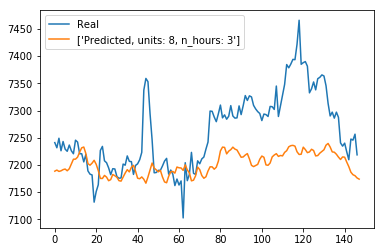

In [64]:
plot_prediciton(26)

# 4 Conclusion

Considering the overall simplicity of the model, the results were quite good, based on optical assessment. Further steps would have been including also the loss-function and the optimizier-algorithm into the hyper-parameter omptimization. Moreover, it would make sense to consider other goodness-measures. Furthermore, it would make sense to inlcude more features based on the sentinment as for example n-grams or include the trading-volume. An other interesting concept would be multi-step time series forecasting. Furhter literature would be [6].

# Literature

[1] https://textblob.readthedocs.io/en/dev/
[2] https://keras.io/layers/about-keras-layers/
[3] https://github.com/taspinar/twitterscraper/
[4] https://github.com/OleBo/Prediction-Models-Finance/blob/master/dataset/downloader_crypto.py
[5] Hands-On Machine Learning with Scikit-Learn
and TensorFlow, Aurélien Géron
[6] https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/